<a href="https://colab.research.google.com/github/Joovvhan/korean-stt/blob/master/notebooks/floatError_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa # librosa: Audio handling package
import random
import copy

from tqdm import tqdm_notebook as tqdm # tqdm: Pakage for progress bar visualization
from datetime import datetime

In [94]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [95]:
n_mels = 160
fs = 62500
frame_length_ms=80
frame_shift_ms=40
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'



with open(meta_path, encoding='utf-8') as f:
    metadata = np.array([line.strip().split('|') for line in f])

max_sequence_len = max(list(map(len, metadata[:, 1])))

# The number of sentences which have wrong labels
error_jamos = [5868, 5998, 6046, 6155, 6202, 
               6654, 6890, 7486, 7502, 7744, 
               7765, 8267, 9069, 9927, 10437, 
               10515, 10533, 10606, 10610, 12777]


# Wrong label comparison
print(list(metadata[0, 3])) # Correct
print(list(metadata[error_jamos[0], 3])) # Wrong


# Delete wrong data and check the length
print(metadata.shape)
metadata = np.delete(metadata, error_jamos, axis = 0)
print(metadata.shape)

# Fix the size of the dataset as a deleted metadata length
dataset_size = len(metadata)

['ᄀ', 'ᅳ', 'ᄂ', 'ᅳ', 'ᆫ', ' ', 'ᄀ', 'ᅫ', 'ᆫ', 'ᄎ', 'ᅡ', 'ᆭ', 'ᄋ', 'ᅳ', 'ᆫ', ' ', 'ᄎ', 'ᅥ', 'ᆨ', 'ᄒ', 'ᅡ', 'ᄅ', 'ᅧ', 'ᄀ', 'ᅩ', ' ', 'ᄋ', 'ᅢ', 'ᄊ', 'ᅳ', 'ᄂ', 'ᅳ', 'ᆫ', ' ', 'ᄀ', 'ᅥ', 'ᆺ', ' ', 'ᄀ', 'ᅡ', 'ᇀ', 'ᄋ', 'ᅡ', 'ᆻ', 'ᄃ', 'ᅡ', '.']
['인', '터', '넷', ' ', '서', '핑', ' ', '중', '이', '에', '요', '.']
(12853, 5)
(12833, 5)


In [96]:
print(nsc)
print(nov)
print(nhop)

5000
2500
2500


In [0]:
# 여기서 테스트 시간 줄이는 걸 할 겁니다.
# 데이터 20개만 보는 걸로
# metadata = metadata[:100, :]

In [0]:
character_length = list() # List of the length of labels
file_length = list() # List of the length of a wav file as sec.
division_length = list() # List of (length of a wav file / length of a label)

for i in range(len(metadata)):
    character_length.append(len(metadata[i, 3]))
    file_length.append(float(metadata[i, 4]))
    division_length.append(float(metadata[i, 4]) * 1000 / len(metadata[i, 3]))

In [0]:
wave_name_list = [] # List of wav file names

for data in metadata:
    wave_name_list.append(data[0])

In [100]:
unicode_jamo_list = list() # List of total hanguel jamos + [' ', ',', '<eos>', 'sos', '!', '?', '-']

# 초성
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode)) # chr: Change hexadecimal to unicode
    
# 중성
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
    
# 종성
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
    
unicode_jamo_list += [' ', '!', ',', '.', '?', '<sos>', '<eos>']
    

unicode_jamo_list.sort()

# '-' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
unicode_jamo_list = ['-'] + unicode_jamo_list

# Check the symbols
print(unicode_jamo_list)

# Check the total number of symbols
print(len(unicode_jamo_list))

['-', ' ', '!', ',', '.', '<eos>', '<sos>', '?', 'ᄀ', 'ᄁ', 'ᄂ', 'ᄃ', 'ᄄ', 'ᄅ', 'ᄆ', 'ᄇ', 'ᄈ', 'ᄉ', 'ᄊ', 'ᄋ', 'ᄌ', 'ᄍ', 'ᄎ', 'ᄏ', 'ᄐ', 'ᄑ', 'ᄒ', 'ᅡ', 'ᅢ', 'ᅣ', 'ᅤ', 'ᅥ', 'ᅦ', 'ᅧ', 'ᅨ', 'ᅩ', 'ᅪ', 'ᅫ', 'ᅬ', 'ᅭ', 'ᅮ', 'ᅯ', 'ᅰ', 'ᅱ', 'ᅲ', 'ᅳ', 'ᅴ', 'ᅵ', 'ᆨ', 'ᆩ', 'ᆪ', 'ᆫ', 'ᆬ', 'ᆭ', 'ᆮ', 'ᆯ', 'ᆰ', 'ᆱ', 'ᆲ', 'ᆳ', 'ᆴ', 'ᆵ', 'ᆶ', 'ᆷ', 'ᆸ', 'ᆹ', 'ᆺ', 'ᆻ', 'ᆼ', 'ᆽ', 'ᆾ', 'ᆿ', 'ᇀ', 'ᇁ', 'ᇂ']
75


In [0]:
# Tokenizer maps numbers to characters, 8 -> 'ㄱ', 10 -> 'ㄴ'
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [0]:
# Create tokenizer, put the whole symbols in and check the output 
tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [103]:
# Create mel-spectrogam images from wav files, 
# if mel-spectrogram file already exist, just add their names to the mel_path_list
 
mel_path_list = list()

for i, wav_name in enumerate(tqdm(wave_name_list)):
    
    npy_name = wav_name.replace('.wav', '.npy')
    wav_path = os.path.join(data_folder, wav_name)  
    mel_path = os.path.join(data_folder + '/test', npy_name)
    mel_path_list.append(mel_path)
    
    # If you have already saved mel-spectrogram, skip mel creating process
    if not os.path.isfile(mel_path):
        
        y, sr = librosa.core.load(wav_path, sr=fs) # I made a mistake... sr=fs 죄송... 이거 넣어야 반영이 되는데, 실수로 안 넣음... fs=22050으로 강제 변환 되고 있음 ㅠㅜ
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)
#       Sxx = np.maximum(Sxx, eps)

        # mel_filters: (n_fft, n_mels)
        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

        # log10(0) is minus infinite, so replace mel_specgram values smaller than 'eps' as 'eps' (1e-8)
        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        
        # 20 * log10(eps) = 20 * -8 = -160
        # -160 is the smallest value
        # Add 160 and divide by 160 => Normalize value between 0 and 1
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref

        np.save(mel_path, norm_log_mel_specgram)

In [0]:
class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
         
        # (B, T, F)
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
                
        
        # (B, T, H)
        
        output_tensor, _ = self.gru(output_tensor)
        
        # (B, T, 2 * H/2)
        
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out):
        super(CTC_Decoder, self).__init__()
        
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.5)
        
        self.gru = nn.GRU(H, D_out, batch_first=True)
        
        self.fc = nn.Linear(D_out, 75)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):

        # (B, T, 2 * H/2)
        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor)
        
        # (B, T, H)
        output_tensor,_ = self.gru(input_tensor)
        
        # (B, T, H)
        output_tensor = self.fc(output_tensor)
        
        # (B, T, 75)
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet():
    def __init__(self, D_in, H, D_out):
        super(Mel2SeqNet, self).__init__()
        
        # Use GPU if GPU is available 
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.encoder = Encoder(D_in, H).to(device)
        self.decoder = CTC_Decoder(H, D_out).to(device)

        self.encoder_optimizer = optim.Adam(self.encoder.parameters(), lr=0.001)
        self.decoder_optimizer = optim.Adam(self.decoder.parameters(), lr=0.001)

        self.ctc_loss = nn.CTCLoss().to(device)
        
        # Initialize weights with random uniform numbers with range
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)

    def train(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        # Shape of the input tensor (B, T, F)
        # B: Number of a batch (8, 16, or 64 ...)
        # T: Temporal length of an input
        # F: Number of frequency band, 80
        
        batch_size = input_tensor.shape[0]

        self.encoder_optimizer.zero_grad()
        self.decoder_optimizer.zero_grad()

        # print('Input Tensor Shape: {}'.format(input_tensor.shape))

        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)

        # print('Encoded Tensor Shape: {}'.format(encoded_tensor.shape))

        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)

        # print('Prediction Tensor Shape: {}'.format(pred_tensor.shape))
        # print(pred_tensor)
            
        # Cast true sentence as Long data type, since CTC loss takes long tensor only
        # Shape (B, S)
        # S: Max length among true sentences 
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        # CTC loss function takes tensor of the form (T, B, 75)
        # Permute function changes axes of a tensor T <-> B
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        # CTC loss need to know the lenght of the true sentence
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
        # print("Target Lengths: {}".format(target_lengths))

        for i in range(target_lengths.shape[0]):
            if target_lengths[i] > pred_tensor.shape[0]:
                target_lengths[i] = pred_tensor.shape[0]

        # print("Target Lengths: {}".format(target_lengths))

        # Calculate CTC Loss
        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

        # print("Loss: {}".format(loss))
        
        # Calculate loss
        loss.backward()

        # Update weights
        self.encoder_optimizer.step()
        self.decoder_optimizer.step()

        # print("Ground Truth Shape: {}".format(ground_truth.shape))
        
        # Return loss divided by true length because loss is sum of the character losses
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    
    def test(self, input_tensor, ground_truth, loss_mask, target_lengths):
        
        # Shape of the input tensor (B, T, F)
        # B: Number of a batch (8, 16, or 64 ...)
        # T: Temporal length of an input
        # F: Number of frequency band, 80
        
        batch_size = input_tensor.shape[0]

        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)

        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
            
        # Cast true sentence as Long data type, since CTC loss takes long tensor only
        # Shape (B, S)
        # S: Max length among true sentences 
        truth = ground_truth
        truth = truth.type(torch.cuda.LongTensor)
        
        # CTC loss function takes tensor of the form (T, B, 75)
        # Permute function changes axes of a tensor T <-> B
        pred_tensor = pred_tensor.permute(1, 0, 2)
              
        # CTC loss need to know the lenght of the true sentence
        input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)
        
        for i in range(target_lengths.shape[0]):
            if target_lengths[i] > pred_tensor.shape[0]:
                target_lengths[i] = pred_tensor.shape[0]

        # Calculate CTC Loss
        loss = self.ctc_loss(pred_tensor, truth, input_lengths, target_lengths)
        
        # Return loss divided by true length because loss is sum of the character losses
        
        return pred_tensor, loss.item() / ground_truth.shape[1]
    
    def save(self, check_point_name):
        torch.save({
            'encoder_state_dict': self.encoder.state_dict(),
            'decoder_state_dict': self.decoder.state_dict(),
            'encoder_optimizer_state_dict': self.encoder_optimizer.state_dict(),
            'decoder_optimizer_state_dict': self.decoder_optimizer.state_dict(),
            }, check_point_name)
    
    def load(self, check_point_name):
        checkpoint = torch.load(check_point_name)
        self.encoder.load_state_dict(checkpoint['encoder_state_dict'])
        self.decoder.load_state_dict(checkpoint['decoder_state_dict'])
        self.encoder_optimizer.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
        self.decoder_optimizer.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
        
    def set_mode(self, mode):
        
        # Must call .train() after loading if you want to train again
        if mode == 'train':
            self.encoder.train()
            self.decoder.train()
        
        # Must call .eval() after loading if you do not want to use dropouts
        elif mode == 'eval':
            self.encoder.eval()
            self.decoder.eval()
            
        else:
            print("Invalid mode string: {}".format(mode))
    
# net = Mel2SeqNet(80, 512, 256)

net = Mel2SeqNet(160, 1024, 512)

In [105]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")      
print(device)

cuda:0


In [0]:
class Batched_Preloader():
    def __init__(self, mel_path_list, ground_truth_list, batch_size):
        super(Batched_Preloader).__init__()
        self.mel_path_list = mel_path_list
        self.total_num_input = len(mel_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
#         self.shuffle_step = 4
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = True
        self.batch_size = batch_size
    
    # Load the spectrogram image from the disk
    def load(self, i):
        norm_log_mel_specgram = np.load(self.mel_path_list[i])
        
        # (F, T) -> (T, F)
        input_spectrogram = norm_log_mel_specgram.T
        
        # (T, F) -> (1, T, F)
        # Inserted the first axis to make stacking easier
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        self.tensor_input_list[i] = tensor_input
    
    # Check if tensor number i is already loaded, if not load and returns the image
    def get(self, i):
        if type(self.tensor_input_list[i]) == type(None):
            self.load(i)
        return self.tensor_input_list[i]  
    
    # Try loading every images
    def initialize_preloader(self):
        for i in tqdm(range(self.total_num_input)):
            self.load(i)
        
        return
    
    # Shuffle loading index and set end flag to false
    def initialize_batch(self):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])
        
        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        
        self.loading_sequence = loading_sequence
        self.current_loading_index = 0
        self.end_flag = False
        
        return
    
    # Get batch
    def get_batch(self):
        
        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            # If there is no more file, break and set end_flag true
            if self.current_loading_index >= self.total_num_input:
                self.end_flag = True
                break
            
            tensor = self.get(self.loading_sequence[self.current_loading_index])
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.loading_sequence[self.current_loading_index]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.current_loading_index += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order].float()
        
            pad_random = np.random.randint(0, 5)
            
            # Time shift, add zeros in front of an image
            if pad_random > 0:
                offset = torch.zeros(target.shape[0], pad_random, target.shape[2]).float()
                target = torch.cat((offset, target), 1).float()
            
            # Add random noise
#             target = target + (torch.rand(target.shape, dtype=torch.double) - 0.5) / 20
            target = target.float() + (torch.rand(target.shape) - 0.5) / 20
        
            # Value less than 0 or more than 1 is clamped to 0 and 1
            target = torch.clamp(target, min=0.0, max=1.0)
            
            batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target.float()
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order]).float()
            
            # You do not need to know what loss mask is 
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order]).float()
        
        return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list


In [0]:
# Create true sentence list, <eos> is added to the end
ground_truth_list = [(tokenizer.word2num(list(metadata[i, 3]) + ['<eos>'])) for i in range(len(metadata))]

In [108]:
print(len(mel_path_list))

print(len(ground_truth_list))

# 80% of the data will be used as train
split_index = int(0.8 * len(mel_path_list))

# Split index is the number stands for 80%
print(split_index)

# Split index is the number stands for 80%
mel_path_list_train = mel_path_list[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]

print(len(mel_path_list_train))

mel_path_list_eval = mel_path_list[split_index:]
ground_truth_list_eval = ground_truth_list[split_index:]

print(len(mel_path_list_eval))

12833
12833
10266
10266
2567


In [110]:
# preloader = Batched_Preloader(mel_path_list, ground_truth_list, 64)

preloader_eval = Batched_Preloader(mel_path_list_eval, ground_truth_list_eval, 64)
preloader_eval.initialize_preloader()

preloader_train = Batched_Preloader(mel_path_list_train, ground_truth_list_train, 64)
preloader_train.initialize_preloader()

In [0]:
# Function that interprets the CTC prediction result

def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem
        
    
    result = np.asarray(result)
    
    return result

In [0]:
# 'keyword' determines the save keyword
# Change this keyword if you want to start training a new model
keyword = 'float_error_debug'

# List of loss values
loss_history_train = list()
loss_history_eval = list()

# try:
#     loss_history_train = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword)).tolist()
#     loss_history_eval = np.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword)).tolist()
# except:
#     print("Loading Failed")

09-13 04:49:15
Mean Train Loss: 0.08349524713955626
Mean Evaluation Loss: 0.08345297773382328
-------------------------------------------------------------------------------------------------------
09-13 04:49:36
Mean Train Loss: 0.07965825421419143
Mean Evaluation Loss: 0.08220549862491495
-------------------------------------------------------------------------------------------------------
09-13 04:49:58
Mean Train Loss: 0.07940195470649575
Mean Evaluation Loss: 0.0826343610141125
-------------------------------------------------------------------------------------------------------
09-13 04:50:19
Mean Train Loss: 0.0796123234206957
Mean Evaluation Loss: 0.08380219196318264
-------------------------------------------------------------------------------------------------------
09-13 04:50:41
Mean Train Loss: 0.07880168429532741
Mean Evaluation Loss: 0.08111076705584216
-------------------------------------------------------------------------------------------------------
09-13 04:51:

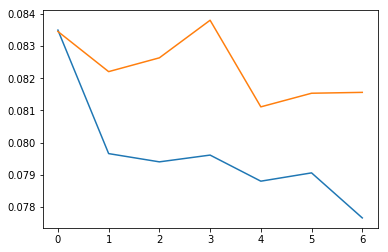

이느                                                                          ᄋᄋᄋᆻ아.<eos>
이느 ᄋᆻ아.<eos>
저는 귀가 어두운데 다른 사람의 얘기를 아주 잘 들어 준다는 말을 많이 들어왔어요.<eos>-----------


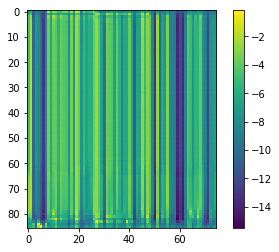

이느                                                             ᄋᄋᄋᆻ아.<eos>
이느 ᄋᆻ아.<eos>
우리 대학에는 외국인 유학생을 위한 한국어 강좌가 마련되어 있습니다.<eos>--------


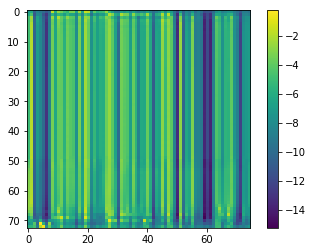

-------------------------------------------------------------------------------------------------------
09-13 04:51:46
Mean Train Loss: 0.0795369475109005
Mean Evaluation Loss: 0.08123750127154412
-------------------------------------------------------------------------------------------------------
09-13 04:52:08
Mean Train Loss: 0.0791046178986895
Mean Evaluation Loss: 0.08162081074459254
-------------------------------------------------------------------------------------------------------
09-13 04:52:29
Mean Train Loss: 0.07923007411261311
Mean Evaluation Loss: 0.08087079626803656
-------------------------------------------------------------------------------------------------------
09-13 04:52:50
Mean Train Loss: 0.07600072547013309
Mean Evaluation Loss: 0.08179991236009991
-------------------------------------------------------------------------------------------------------
09-13 04:53:12
Mean Train Loss: 0.08009447303476688
Mean Evaluation Loss: 0.08027868928336088
------------

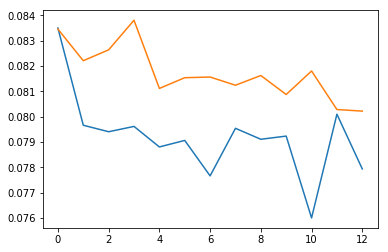

으 ᄋ                                                    알ᄋ      ------ᄋ이다.<eos>
으 ᄋ 알ᄋ 이다.<eos>
최근 복싱이 다이어트에 효과적이라고 알려지면서 복싱을 하는 여자들이 늘고 있어요.<eos>-----------


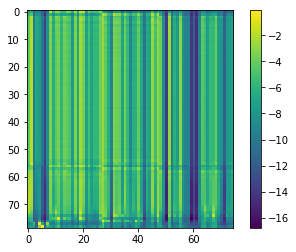

으                                             아           -----ᄋᄋ이다.<eos>
으 아 이다.<eos>
옛날에는 학생들의 손바닥을 자로 때리는 선생님들이 있었어요.<eos>--------------


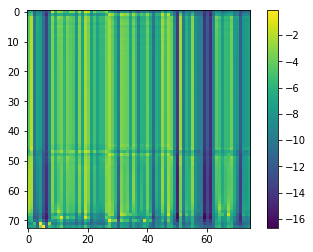

-------------------------------------------------------------------------------------------------------
09-13 04:53:55
Mean Train Loss: 0.07777950418522836
Mean Evaluation Loss: 0.07867538988941274
-------------------------------------------------------------------------------------------------------
09-13 04:54:17
Mean Train Loss: 0.07769039610164082
Mean Evaluation Loss: 0.08083430514471147
-------------------------------------------------------------------------------------------------------
09-13 04:54:38
Mean Train Loss: 0.07963358155969984
Mean Evaluation Loss: 0.08014588007277261
-------------------------------------------------------------------------------------------------------
09-13 04:54:59
Mean Train Loss: 0.07739558424536339
Mean Evaluation Loss: 0.07863303950607603
-------------------------------------------------------------------------------------------------------
09-13 04:55:21
Mean Train Loss: 0.07696776728536354
Mean Evaluation Loss: 0.08019319838866576
----------

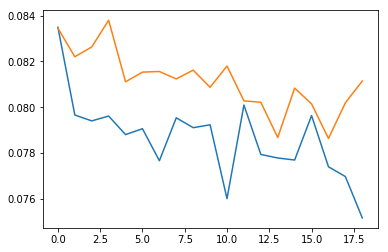

으 ᄋ                                                      가                   ᆸ이다.<eos>
으 ᄋ 가 ᆸ이다.<eos>
감옥에 몇 년간 형을 살고 나온 후 그는 착실하게 살겠다고 마음먹었다.<eos>--------------------


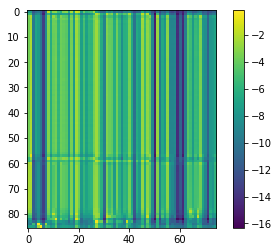

으느ᅳ                                              그             ᆸ이다.<eos>
으느 그 ᆸ이다.<eos>
저는 그 사람이 나이 어린 여자들을 대하는 태도가 마음에 안 들어요.<eos>---------------


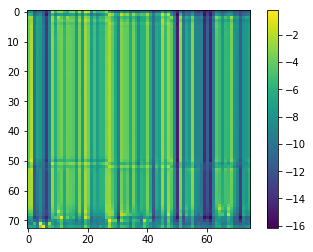

-------------------------------------------------------------------------------------------------------
09-13 04:56:04
Mean Train Loss: 0.07595841644965955
Mean Evaluation Loss: 0.07899249783465034
-------------------------------------------------------------------------------------------------------
09-13 04:56:25
Mean Train Loss: 0.07684171217183215
Mean Evaluation Loss: 0.07935906585610897
-------------------------------------------------------------------------------------------------------
09-13 04:56:46
Mean Train Loss: 0.07667807879720479
Mean Evaluation Loss: 0.07811209152048977
-------------------------------------------------------------------------------------------------------
09-13 04:57:08
Mean Train Loss: 0.07540683123250497
Mean Evaluation Loss: 0.07694421239217207
-------------------------------------------------------------------------------------------------------
09-13 04:57:30
Mean Train Loss: 0.07376406851137705
Mean Evaluation Loss: 0.07989548018847148
----------

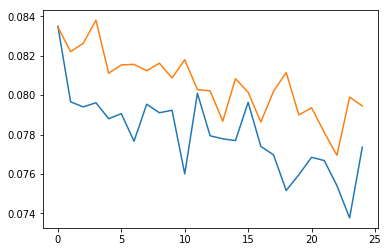

아 ᅡ                                                   ᅡᅡ      -- ---- --- ----ᄋ니다.<eos>
아 ᅡ ᅡ    ᄋ니다.<eos>
보일러가 고장 났다는 초기 신호는 온수가 안 나오거나 난방이 안 될 때입니다.<eos>-----------------


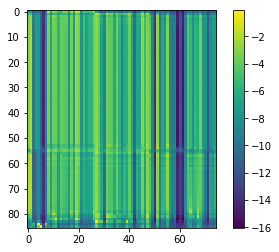

아 ᅡᄋᄋ                                                 ᅡᅡ         ᆸ니다.<eos>
아 ᅡᄋ ᅡ ᆸ니다.<eos>
저녁 일곱 시 이전에 오시는 손님께는 소주 한 병을 서비스로 제공합니다.<eos>-------


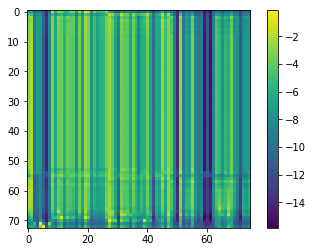

-------------------------------------------------------------------------------------------------------
09-13 04:58:13
Mean Train Loss: 0.07625800114006215
Mean Evaluation Loss: 0.07874198384313671
-------------------------------------------------------------------------------------------------------
09-13 04:58:34
Mean Train Loss: 0.0768778300144159
Mean Evaluation Loss: 0.07902709952415653
-------------------------------------------------------------------------------------------------------
09-13 04:58:56
Mean Train Loss: 0.07668984983910479
Mean Evaluation Loss: 0.07825480130217952
-------------------------------------------------------------------------------------------------------
09-13 04:59:18
Mean Train Loss: 0.07746324760206359
Mean Evaluation Loss: 0.0807692992487117
-------------------------------------------------------------------------------------------------------
09-13 04:59:39
Mean Train Loss: 0.07973036727609076
Mean Evaluation Loss: 0.08045585100884978
------------

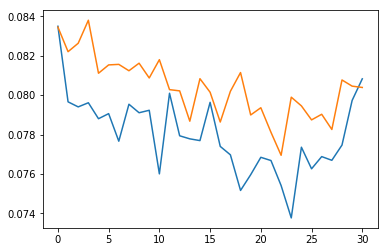

아                                                                          ᄋᄋᄋᄋᄋᆻ다.<eos>
아 ᄋᆻ다.<eos>
일 년에 두세 차례 본사에서 기술자들이 파견되어 현지 직원들과 협업합니다.<eos>-------------------


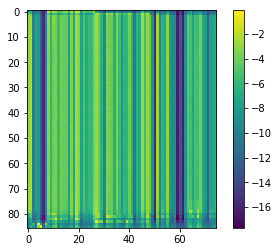

아                                                            ᄋᄋᄋᄋᄋᄋᆻ다.<eos>
아 ᄋᆻ다.<eos>
옛날에는 학생들의 손바닥을 자로 때리는 선생님들이 있었어요.<eos>--------------


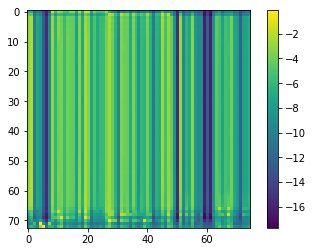

-------------------------------------------------------------------------------------------------------
09-13 05:00:22
Mean Train Loss: 0.08010879260083788
Mean Evaluation Loss: 0.08029748744299502
-------------------------------------------------------------------------------------------------------
09-13 05:00:44
Mean Train Loss: 0.08096776545485414
Mean Evaluation Loss: 0.08026773557956178
-------------------------------------------------------------------------------------------------------
09-13 05:01:05
Mean Train Loss: 0.07879893739835117
Mean Evaluation Loss: 0.07901810179368864
-------------------------------------------------------------------------------------------------------
09-13 05:01:26
Mean Train Loss: 0.07817377155370517
Mean Evaluation Loss: 0.07994346027368184
-------------------------------------------------------------------------------------------------------
09-13 05:01:47
Mean Train Loss: 0.07839018677844269
Mean Evaluation Loss: 0.07954885713855488
----------

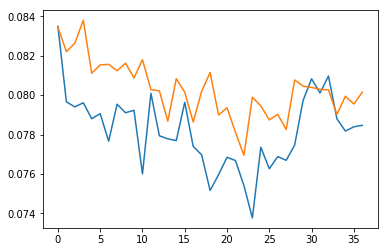

아                                                                            ᄋᄋᄋᆻ다.<eos>
아 ᄋᆻ다.<eos>
사람들은 멀리 있는 사람을 부를 때 손을 오목하게 만들어 입가에 댑니다.<eos>-------------------


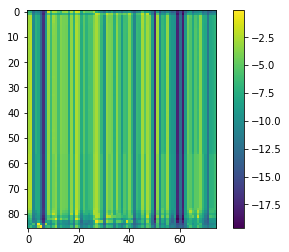

아                                                               ᄋᄋᄋᆻ다.<eos>
아 ᄋᆻ다.<eos>
그 사람하고 십 분 이상 간 얘기한다는 게 나로서는 여간 힘든 일이 아냐.<eos>--------


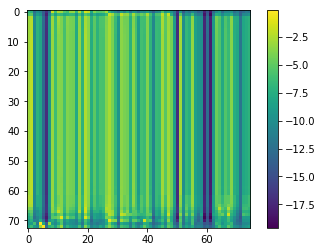

-------------------------------------------------------------------------------------------------------
09-13 05:02:30
Mean Train Loss: 0.07877125931470996
Mean Evaluation Loss: 0.08008453892434904
-------------------------------------------------------------------------------------------------------
09-13 05:02:51
Mean Train Loss: 0.07929938363996578
Mean Evaluation Loss: 0.07977443760463794
-------------------------------------------------------------------------------------------------------
09-13 05:03:13
Mean Train Loss: 0.07826550994499609
Mean Evaluation Loss: 0.07942029441056617
-------------------------------------------------------------------------------------------------------
09-13 05:03:34
Mean Train Loss: 0.07822422533240996
Mean Evaluation Loss: 0.07885676013638433
-------------------------------------------------------------------------------------------------------
09-13 05:03:55
Mean Train Loss: 0.0776524541043348
Mean Evaluation Loss: 0.07915035923889034
-----------

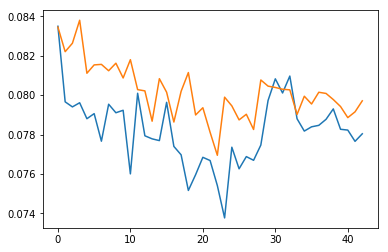

아느                                                                   -ᆸᄋᆻ다.<eos>
아느 ᆸᄋᆻ다.<eos>
이 수의 십의 자리 숫자는 일의 자리 숫자의 세 배이다. 각 숫자의 합은 팔이다. 이 수는?<eos>---------


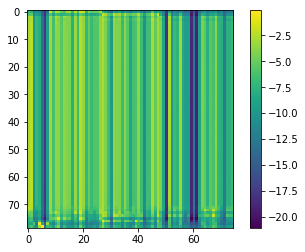

아느                                                            --ᆸᄋᆻ다.<eos>
아느 ᆸᄋᆻ다.<eos>
그 사람하고 십 분 이상 간 얘기한다는 게 나로서는 여간 힘든 일이 아냐.<eos>--------


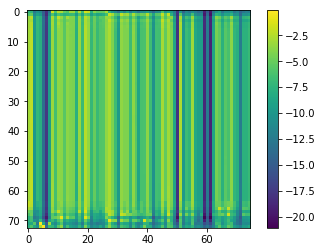

-------------------------------------------------------------------------------------------------------
09-13 05:04:38
Mean Train Loss: 0.07826575285243312
Mean Evaluation Loss: 0.07940789955142925
-------------------------------------------------------------------------------------------------------
09-13 05:05:00
Mean Train Loss: 0.07780295013752869
Mean Evaluation Loss: 0.07877932169430069
-------------------------------------------------------------------------------------------------------
09-13 05:05:21
Mean Train Loss: 0.07814569121566557
Mean Evaluation Loss: 0.0796783282573516
-------------------------------------------------------------------------------------------------------
09-13 05:05:42
Mean Train Loss: 0.079199288417394
Mean Evaluation Loss: 0.0796412008133591
-------------------------------------------------------------------------------------------------------
09-13 05:06:04
Mean Train Loss: 0.07786665262640516
Mean Evaluation Loss: 0.07957533122850956
--------------

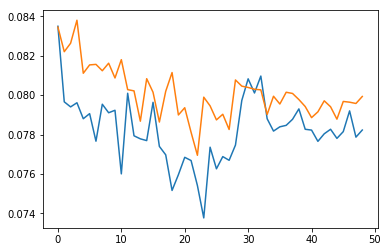

아느                                                         -------------------ᄋᆻ다.<eos>
아느 ᄋᆻ다.<eos>
보일러가 고장 났다는 초기 신호는 온수가 안 나오거나 난방이 안 될 때입니다.<eos>-----------------


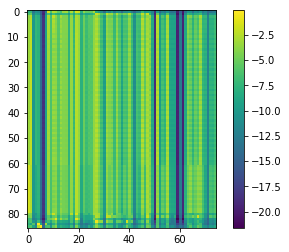

아느                                              -----------------ᄋᆻ다.<eos>
아느 ᄋᆻ다.<eos>
연간 오백만 명의 외국인 관광객들이 서울을 방문하고 있다.<eos>-----------------


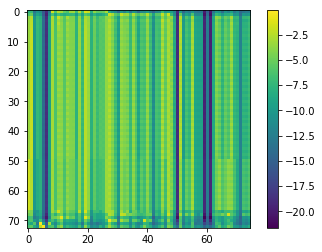

-------------------------------------------------------------------------------------------------------
09-13 05:06:47
Mean Train Loss: 0.07807030548881337
Mean Evaluation Loss: 0.08352606958578469
-------------------------------------------------------------------------------------------------------
09-13 05:07:08
Mean Train Loss: 0.07793703926716931
Mean Evaluation Loss: 0.08166664226577902
-------------------------------------------------------------------------------------------------------
09-13 05:07:29
Mean Train Loss: 0.08167015078362366
Mean Evaluation Loss: 0.08025848612404037
-------------------------------------------------------------------------------------------------------
09-13 05:07:50
Mean Train Loss: 0.0785825860456806
Mean Evaluation Loss: 0.07970443858140237
-------------------------------------------------------------------------------------------------------
09-13 05:08:11
Mean Train Loss: 0.07864744629950476
Mean Evaluation Loss: 0.07972733335086797
-----------

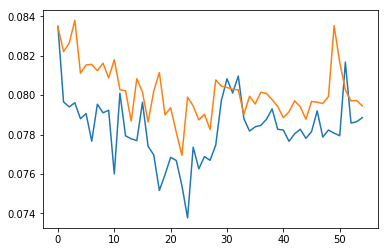

아                                                          --------------------ᄋᆻ다.<eos>
아 ᄋᆻ다.<eos>
부모가 저지르는 큰 실수 중 하나는 자기 아이를 다른 집 아이와 비교하는 것이다.<eos>-----------------


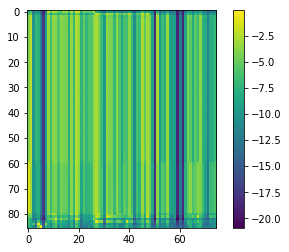

아                                                    -------------ᄋᆻ다.<eos>
아 ᄋᆻ다.<eos>
눈 수술을 했기 때문에 태양으로부터 눈을 보호하려고 선글라스를 써요.<eos>-----------


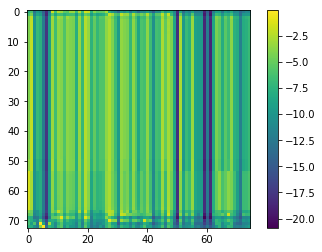

-------------------------------------------------------------------------------------------------------
09-13 05:08:54
Mean Train Loss: 0.07879274125403549
Mean Evaluation Loss: 0.07934764745750751
-------------------------------------------------------------------------------------------------------
09-13 05:09:15
Mean Train Loss: 0.0782388490382461
Mean Evaluation Loss: 0.07915805313585009
-------------------------------------------------------------------------------------------------------
09-13 05:09:36
Mean Train Loss: 0.07808818591777268
Mean Evaluation Loss: 0.079893729199615
-------------------------------------------------------------------------------------------------------
09-13 05:09:57
Mean Train Loss: 0.07839562436256588
Mean Evaluation Loss: 0.07882478375065148
-------------------------------------------------------------------------------------------------------
09-13 05:10:19
Mean Train Loss: 0.07773915883924434
Mean Evaluation Loss: 0.07871670284812318
-------------

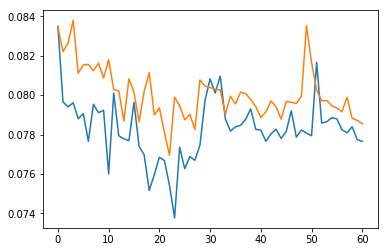

아ᄂ                                                               --------------ᄋᆻ다.<eos>
아ᄂ ᄋᆻ다.<eos>
우리는 외국인 근로자들의 권익을 보호하기 위해 계속해서 최선을 다할 것입니다.<eos>--------------


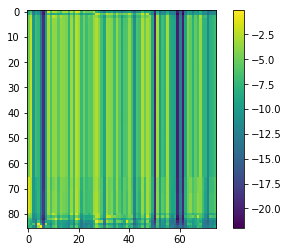

아ᄂ                                                      ----------ᄋᆻ다.<eos>
아ᄂ ᄋᆻ다.<eos>
올해 장마는 유월 중순에 시작해서 칠 월 초에 끝날 것으로 예상됩니다.<eos>--------


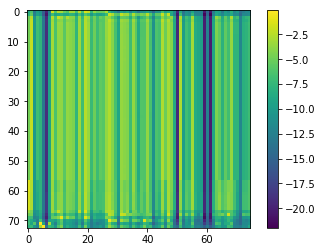

-------------------------------------------------------------------------------------------------------
09-13 05:11:02
Mean Train Loss: 0.07770236156224485
Mean Evaluation Loss: 0.0782888298351628
-------------------------------------------------------------------------------------------------------
09-13 05:11:24
Mean Train Loss: 0.0776564183776298
Mean Evaluation Loss: 0.07933799168494783
-------------------------------------------------------------------------------------------------------
09-13 05:11:45
Mean Train Loss: 0.07812265706853577
Mean Evaluation Loss: 0.07870231266851653
-------------------------------------------------------------------------------------------------------
09-13 05:12:06
Mean Train Loss: 0.07783404753960624
Mean Evaluation Loss: 0.07899438339912276
-------------------------------------------------------------------------------------------------------
09-13 05:12:28
Mean Train Loss: 0.07799162613535601
Mean Evaluation Loss: 0.07957069381525658
------------

In [0]:
EPOCH = 3 * 60 * 4
    
# Load model if model weights already exists
# try:
#     net.load('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
# except:
#     print("Loading Error")
    
for epoch in range(EPOCH):
    
    print(datetime.now().strftime('%m-%d %H:%M:%S'))
    
    net.set_mode('train')
    preloader_train.initialize_batch()
    loss_list_train = list()
    
    while preloader_train.end_flag == False:
        tensor_input, ground_truth, loss_mask, length_list = preloader_train.get_batch()
        pred_tensor, loss = net.train(tensor_input.to(device), ground_truth.to(device), loss_mask.to(device), length_list.to(device))
        loss_list_train.append(loss)

    print("Mean Train Loss: {}".format(np.mean(np.asarray(loss_list_train))))
    loss_history_train.append(np.mean(np.asarray(loss_list_train)))
    
    net.set_mode('eval')
    preloader_eval.initialize_batch()
    loss_list_eval = list()
    
    while preloader_eval.end_flag == False:
        tensor_input, ground_truth_, loss_mask, length_list = preloader_eval.get_batch()
        pred_tensor_, loss = net.test(tensor_input.to(device), ground_truth_.to(device), loss_mask.to(device), length_list.to(device))
        loss_list_eval.append(loss)

    print("Mean Evaluation Loss: {}".format(np.mean(np.asarray(loss_list_eval))))
    loss_history_eval.append(np.mean(np.asarray(loss_list_eval)))
    
    
    net.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/{}'.format(keyword))
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_train_{}.npy'.format(keyword), loss_history_train)
    np.save('gdrive/My Drive/korean-single-speaker-speech-dataset/kss/model_saved/loss_history_eval_{}.npy'.format(keyword), loss_history_eval)
    
    
    if ((epoch != 0) and (epoch % 6 == 0)):
        
        plt.figure()
        plt.plot(loss_history_train)
        plt.plot(loss_history_eval)
        plt.show()
        
        # index is the position of the max probility of the first batch
        # Shape of the pred_tensor: (T, B, 75)
        # Shape of the index: (T)
        _, index = pred_tensor[:, 0, :].max(-1)

        # Change index numbers to character
        sentence = tokenizer.num2word(index.view(-1))
        
        # Change list to string
        print(''.join(sentence))
        
        # Remove "blank" and overlapping characters
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        
        true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        # Plot image
        # detach().cpu().numpy() transforms a tensor on gpu into a numpy matrix
        plt.figure()
        plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        _, index = pred_tensor_[:, 0, :].max(-1)

        sentence = tokenizer.num2word(index.view(-1))
        print(''.join(sentence))
        index_ = Decode_CTC_Prediction(index)
        sentence_ = tokenizer.num2word(index_)
        print(''.join(sentence_))
        true_sentence = tokenizer.num2word(ground_truth_[0, :].detach().numpy().astype(int))
        print(''.join(true_sentence))

        plt.figure()
        plt.imshow(pred_tensor_[:, 0, :].detach().cpu().numpy())
        plt.colorbar()
        plt.show()
        
        
                        
    print("-------------------------------------------------------------------------------------------------------")